In [1]:
import os
import glob
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import pydicom

from sklearn.model_selection import train_test_split


def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [2]:
# improved_df = pd.read_csv('/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv')
# train_series_description= pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
# train_series_description = train_series_description[train_series_description['series_description'] == "Sagittal T2/STIR"]
# train_data  = pd.merge(improved_df, train_series_description, on=['study_id', 'series_id'], how='inner')

In [3]:
# train_series_description

In [4]:
# train_series_description['series_description'].unique()

# Read Instance of image

In [5]:
# dcm = pydicom.dcmread('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/105895264/3528018752/10.dcm')
# resized_image = cv2.resize( np.array(dcm.pixel_array), (224, 224), interpolation=cv2.INTER_AREA)
# plt.imshow(resized_image)
# plt.show()

## Lumbar Coordinate Dataset


This notebook shows how the [Lumbar Coordinate Dataset](https://www.kaggle.com/datasets/brendanartley/lumbar-coordinate-pretraining-dataset) can be used in the RSNA 2024 competition. First I will showcase improved coordinates for the competition data, and then I will showcase using external data to pretrain backbones.

## 1. Improved RSNA Coordinates


We improve the competition coordinates by labelling the left side of each disc. This gives us the angle of orientation which can be used to improve cropping of each disc.

Thanks to [Ian Pan](https://www.kaggle.com/vaillant) for sharing some helper functions for loading the dicom data. See his great notebook [here](https://www.kaggle.com/code/vaillant/cross-reference-images-in-different-mri-planes?scriptVersionId=182551992&cellId=2).

In [6]:
# def convert_to_8bit(x):
#     lower, upper = np.percentile(x, (1, 99))
#     x = np.clip(x, lower, upper)
#     x = x - np.min(x)
#     x = x / np.max(x) 
#     return (x * 255).astype("uint8")


# def load_dicom_stack(dicom_folder, plane, reverse_sort=False):
#     dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
#     dicoms = [pydicom.dcmread(f) for f in dicom_files]
#     plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
#     positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
#     # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
#     # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
#     idx = np.argsort(-positions if reverse_sort else positions)
#     ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
#     array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
#     array = array[idx]
#     return {"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}

# image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/"

In [7]:
# resize_transform= A.Compose([
#     A.LongestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC, always_apply=True),
#     A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
# ])

# def angle_of_line(x1, y1, x2, y2):
#     return math.degrees(math.atan2(-(y2-y1), x2-x1))

# def plot_img(img, coords_temp):
#     # Plot img
#     fig, ax = plt.subplots()
#     ax.imshow(img, cmap='gray')
#     h, w = img.shape
    
#     # Kepoints as pairs
#     p= coords_temp.groupby("level") \
#                   .apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False) \
#                   .reset_index(drop=False, name="vals")
    
#     # Plot keypoints
#     for _, row in p.iterrows():
#         level = row['level']
#         x = [_[0]*w for _ in row["vals"]]
#         y = [_[1]*h for _ in row["vals"]]
#         ax.plot(x, y, marker='o')
#     ax.axis('off')
#     plt.show()

# def plot_5_crops(img, coords_temp):
#     # Create a figure and axis for the grid
#     fig = plt.figure(figsize=(10, 10))
#     gs = gridspec.GridSpec(1, 5, width_ratios=[1]*5)
    
#     # Plot the crops
#     p= coords_temp.groupby("level").apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False).reset_index(drop=False, name="vals")
#     for idx, (_, row) in enumerate(p.iterrows()):
#         # Copy of img
#         img_copy= img.copy()
#         h, w = img.shape

#         # Extract Keypoints
#         level = row['level']
#         vals = sorted(row["vals"], key=lambda x: x[0])
#         a,b= vals
#         a= (a[0]*w, a[1]*h)
#         b= (b[0]*w, b[1]*h)

#         # Rotate
#         rotate_angle= angle_of_line(a[0], a[1], b[0], b[1])
#         transform = A.Compose([
#             A.Rotate(limit=(-rotate_angle, -rotate_angle), p=1.0),
#         ], keypoint_params= A.KeypointParams(format='xy', remove_invisible=False),
#         )

#         t= transform(image=img_copy, keypoints=[a,b])
#         img_copy= t["image"]
#         a,b= t["keypoints"]
        
#         # Crop + Resize
#         img_copy= crop_between_keypoints(img_copy, a, b)
#         img_copy= resize_transform(image=img_copy)["image"]
        
#         # Plot
#         ax = plt.subplot(gs[idx])
#         ax.imshow(img_copy, cmap='gray')
#         ax.set_title(level)
#         ax.axis('off')
#     plt.show()
    
    
# def crop_between_keypoints(img, keypoint1, keypoint2):
#     h, w = img.shape
#     x1, y1 = int(keypoint1[0]), int(keypoint1[1])
#     x2, y2 = int(keypoint2[0]), int(keypoint2[1])
    
#     # Calculate bounding box around the keypoints
#     left = int(min(x1, x2))
#     right = int(max(x1, x2))
#     top = int(min(y1, y2) - (h * 0.1))
#     bottom = int(max(y1, y2) + (h * 0.1))
            
#     # Crop the image
#     return img[top:bottom, left:right]

Feel free to change the seed, or increase N to see more samples.

In [8]:
# SEED= 10
# N= 1

# # Load series_ids
# dfd= pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
# dfd= dfd[dfd.series_description == "Sagittal T2/STIR"]
# dfd= dfd.sample(frac=1, random_state=SEED).head(N)

# # Load coords
# coords= pd.read_csv("/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv")
# coords= coords.sort_values(["series_id", "level", "side"]).reset_index(drop=True)
# coords= coords[["series_id", "level", "side", "relative_x", "relative_y"]]

# # Plot samples
# for idx, row in dfd.iterrows():
#     try:
#         print("-"*25, " STUDY_ID: {}, SERIES_ID: {} ".format(row.study_id, row.series_id), "-"*25)
#         sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        
#         # Img + Coords
#         print(len(sag_t2["array"])//2)
#         print(sag_t2["array"].shape[-1])
#         img= sag_t2["array"][len(sag_t2["array"])//2]
#         coords_temp= coords[coords["series_id"] == row.series_id].copy()
#         print(coords_temp)
#         # Plot
#         plot_img(img, coords_temp)
#         plot_5_crops(img, coords_temp)
        
#     except Exception as e:
#         print(e)
#         pass

## 2. Pretraining

Next, I show a simple pipeline to train a model to predict the x,y coordinates of the 5 lower lumbar vertabrae. The idea is that we first train our image model on a similar task so that the model better suited to tackle our main objective. 

This data was put together in the first version so it does not include left side coordinates. 

For more information on the data, see [here](https://www.kaggle.com/datasets/brendanartley/lumbar-coordinate-pretraining-dataset).

<h1 align="left">
<img src="https://storage.googleapis.com/kaggle-datasets-images/5464745/9091594/db0b402668602e8a6eb772a162f47eb3/dataset-cover.png?t=2024-08-02-23-33-03" alt="spine_img" width="700">
</h1>


In [9]:
# Config
cfg= SimpleNamespace(
    img_dir= "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images",
    device= torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    n_frames=3,
    epochs=10,
    lr=0.0005,
    batch_size=16,
    backbone="resnet18",
    seed= 0,
)
set_seed(seed=cfg.seed) # Makes results reproducable

In [10]:
# Load metadata

improved_df = pd.read_csv('/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv')
train_series_description= pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
train_series_description = train_series_description[train_series_description['series_description'] == "Sagittal T2/STIR"]
df  = pd.merge(improved_df, train_series_description, on=['study_id', 'series_id'], how='inner')
#df= pd.read_csv("/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv")
df= df.sort_values(["study_id", "series_id", "level","side"]).reset_index(drop=True)
#df["filename"] = df["filename"].str.replace(".jpg", ".npy")
#df["series_id"] = df["source"] + "_" + df["filename"].str.split(".").str[0]

print("----- IMGS per source -----")
#display((df.study_id.value_counts()/5).astype(int).reset_index())

----- IMGS per source -----


In [11]:
# df['study_id'].nunique()

In [12]:
# df1 = df.head(20)
# d = df1.groupby(["study_id","series_id"])[["relative_x", "relative_y"]].apply(lambda x: list(x.itertuples(index=False, name=None)))
# records= {}
# for i, (k,v) in enumerate(d.items()):
#     records[i]= {"series_id": k, "label": np.array(v).flatten()}
#     assert len(v) == 10

In [13]:
# records

In [14]:
# def pad_image( img):
#         n= img.shape[0]
#         if n >= cfg.n_frames:
#             start_idx = (n - cfg.n_frames) // 2
#             return img[start_idx:start_idx + cfg.n_frames,:, :]
#         else:
#             pad_left = (cfg.n_frames - n) // 2
#             pad_right = cfg.n_frames - n - pad_left
#             return np.pad(img, ((pad_left, pad_right),(0,0), (0,0)), 'constant', constant_values=0)
    
# def load_img( series_id):
#     fname = load_dicom_stack(os.path.join("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images", str(series_id)), plane="sagittal")
#     img= fname["array"]
#     img= pad_image(img)
#     img= (img / 255.0)
#     return img

In [15]:
# d= records[0]
# label= d["label"]
# study_id,series_id = d["series_id"]
# series_id= "/".join([str(study_id),str(series_id)])     


    

In [16]:
# img= load_img(series_id)


In [17]:
# img= np.transpose(img, (1,2, 0))

In [18]:
# resize_transform= A.Compose([
#     A.LongestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC, always_apply=True),
#     A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
# ])

In [19]:
#  img_copy= resize_transform(image=img_copy)["image"]

In [20]:
# plt.imshow(img_copy)

## Dataset

Here we define the torch dataset that will be used during training.

In [56]:
class PreTrainDataset(torch.utils.data.Dataset):
    def __init__(self, study_ids,df ,cfg,transform):
        self.cfg= cfg
        self.records= self.load_coords(df)
        self.study_ids = study_ids
        self.transform = transform

    def load_coords(self, df):
        # Convert to dict
        d = df.groupby(["study_id","series_id"])[["relative_x", "relative_y"]].apply(lambda x: list(x.itertuples(index=False, name=None)))
        records= {}
        for i, (k,v) in enumerate(d.items()):
            records[i]= {"series_id": k, "label": np.array(v).flatten()}
            #print(k)
            #print(len(v))
            assert len(v) == 10
        return records
    
    def convert_to_8bit(self,x):
        lower, upper = np.percentile(x, (1, 99))
        x = np.clip(x, lower, upper)
        x = x - np.min(x)
        x = x / np.max(x) 
        return (x * 255).astype("uint8")


    def load_dicom_stack(self,dicom_folder, plane, reverse_sort=False):
        dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
        dicoms = [pydicom.dcmread(f) for f in dicom_files]
        plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
        positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
        # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
        # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
        idx = np.argsort(-positions if reverse_sort else positions)
        ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
        array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
        array = array[idx]
        return {"array": self.convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}
    
    def pad_image(self, img):
        n= img.shape[0]
        if n >= self.cfg.n_frames:
            start_idx = (n - self.cfg.n_frames) // 2
            return img[start_idx:start_idx + self.cfg.n_frames,:, :]
        else:
            pad_left = (self.cfg.n_frames - n) // 2
            pad_right = self.cfg.n_frames - n - pad_left
            return np.pad(img, ((pad_left, pad_right),(0,0), (0,0)), 'constant', constant_values=0)
    
    def load_img(self, series_id):
        fname = self.load_dicom_stack(os.path.join(self.cfg.img_dir, str(series_id)), plane="sagittal")
        img= fname["array"]
        img= self.pad_image(img)
        img= np.transpose(img, (1,2, 0))
        img= resize_transform(image=img)["image"]
        img= np.transpose(img, (2, 0, 1))
        img= (img / 255.0)
        return img
        
        
    def __getitem__(self, idx):
        d= self.records[idx]
        label= d["label"]
        study_id,series_id = d["series_id"]
        series_id= "/".join([str(study_id),str(series_id)])      
                
        img= self.load_img(series_id)
        return {
            'img': img, 
            'label': label,
            }
    
    def __len__(self,):
        return len(self.records)
    

resize_transform= A.Compose([
A.LongestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC, always_apply=True),
A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
])

df_test_code  = df.head(20)
unique_df_test_code = df[['study_id']].drop_duplicates().reset_index(drop=True)

ds = PreTrainDataset(unique_df_test_code,df_test_code, cfg,resize_transform)    

# Plot a Single Sample
print("---- Sample Shapes -----")
for k, v in ds[1].items():
    print(k, v.shape)


---- Sample Shapes -----
img (3, 256, 256)
label (20,)


## Utils


Here we have a couple helpers functions. 

The first moves data to the GPU if enabled, the second visualizes predictions during training, and the third loads weights when dealing with mismatched shapes.

In [57]:
def batch_to_device(batch, device, skip_keys=[]):
    batch_dict= {}
    for key in batch:
        if key in skip_keys:
             batch_dict[key]= batch[key]
        else:    
            batch_dict[key]= batch[key].to(device)
    return batch_dict

def visualize_prediction(batch, pred, epoch):
    
    mid= cfg.n_frames//2
    
    # Plot
    for idx in range(1):
    
        # Select Data
        img= batch["img"][idx, mid, :, :].cpu().numpy()*255
        cs_true= batch["label"][idx, ...].cpu().numpy()*256
        cs= pred[idx, ...].cpu().numpy()*256
                
        coords_list = [("TRUE", "lightblue", cs_true), ("PRED", "orange", cs)]
        text_labels = [str(x) for x in range(1,21)]
        
        # Plot coords
        fig, axes = plt.subplots(1, len(coords_list), figsize=(10,4))
        fig.suptitle("EPOCH: {}".format(epoch))
        for ax, (title, color, coords) in zip(axes, coords_list):
            ax.imshow(img, cmap='gray')
            ax.scatter(coords[0::2], coords[1::2], c=color, s=50)
            ax.axis('off')
            ax.set_title(title)

            # Add text labels near the coordinates
            for i, (x, y) in enumerate(zip(coords[0::2], coords[1::2])):
                if i < len(text_labels):  # Ensure there are enough labels
                    ax.text(x + 10, y, text_labels[i], color='white', fontsize=15, bbox=dict(facecolor='black', alpha=0.5))


        fig.suptitle("EPOCH: {}".format(epoch))
        plt.show()
#         plt.close(fig)
    return

def load_weights_skip_mismatch(model, weights_path, device):
    # Load Weights
    state_dict = torch.load(weights_path, map_location=device)
    model_dict = model.state_dict()
    
    # Iter models
    params = {}
    for (sdk, sfv), (mdk, mdv) in zip(state_dict.items(), model_dict.items()):
        if sfv.size() == mdv.size():
            params[sdk] = sfv
        else:
            print("Skipping param: {}, {} != {}".format(sdk, sfv.size(), mdv.size()))
    
    # Reload + Skip
    model.load_state_dict(params, strict=False)
    print("Loaded weights from:", weights_path)

## Model Training

Here we train on all sources except for the spider dataset, which is used for validation.

In [23]:
# df = df.head(50)

In [58]:
grouped = df.groupby('study_id').size()
counts_less_than_10 = grouped[grouped == 10]
counts_df = counts_less_than_10.reset_index(name='count')

# Rename columns for clarity
counts_df.columns = ['study_id', 'count']

# Filter for counts less than 10


In [59]:
count_df = counts_df.drop(columns=['count'])

In [60]:
count_df

,study_id
0,4003253
1,4646740
2,7143189
3,8785691
4,10728036
...,...
1966,4282019580
1967,4283570761
1968,4284048608
1969,4287160193


In [61]:
df  = pd.merge(df, count_df, on=['study_id'], how='inner')

In [54]:
df

,Unnamed: 0,series_id,relative_x,relative_y,condition,side,instance_number,study_id,level,series_description
0,9573,702807833,0.347656,0.355469,Spinal Canal Stenosis,L,-1,4003253,L1/L2,Sagittal T2/STIR
1,9574,702807833,0.504425,0.356195,Spinal Canal Stenosis,R,8,4003253,L1/L2,Sagittal T2/STIR
2,9575,702807833,0.343750,0.472656,Spinal Canal Stenosis,L,-1,4003253,L2/L3,Sagittal T2/STIR
3,9576,702807833,0.500893,0.462054,Spinal Canal Stenosis,R,8,4003253,L2/L3,Sagittal T2/STIR
4,9577,702807833,0.343750,0.593750,Spinal Canal Stenosis,L,-1,4003253,L3/L4,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...,...,...
19705,44571,3274612423,0.544460,0.502052,Spinal Canal Stenosis,R,9,4290709089,L3/L4,Sagittal T2/STIR
19706,44572,3274612423,0.406250,0.644531,Spinal Canal Stenosis,L,-1,4290709089,L4/L5,Sagittal T2/STIR
19707,44573,3274612423,0.570451,0.597811,Spinal Canal Stenosis,R,9,4290709089,L4/L5,Sagittal T2/STIR
19708,44574,3274612423,0.457031,0.789062,Spinal Canal Stenosis,L,-1,4290709089,L5/S1,Sagittal T2/STIR


In [62]:
# Split the DataFrame into training and validation sets
unique_df = df[['study_id']].drop_duplicates().reset_index(drop=True)
train_df, val_df = train_test_split(unique_df, test_size=0.2, random_state=42)

train_data_df  = pd.merge(train_df, df, on=['study_id'], how='inner')
val_data_df  = pd.merge(val_df, df, on=['study_id'], how='inner')


# Datasets + Dataloaders
train_ds= PreTrainDataset(train_df,train_data_df, cfg,resize_transform)
val_ds= PreTrainDataset(val_df, val_data_df,cfg,resize_transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)

# Model
model = timm.create_model('resnet18', pretrained=True, num_classes=20)
model = model.to(cfg.device)

# Loss / Optim
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

In [63]:
val_data_df

,study_id,Unnamed: 0,series_id,relative_x,relative_y,condition,side,instance_number,level,series_description
0,1667735473,43244,3194845181,0.355469,0.281250,Spinal Canal Stenosis,L,-1,L1/L2,Sagittal T2/STIR
1,1667735473,43245,3194845181,0.550627,0.297939,Spinal Canal Stenosis,R,11,L1/L2,Sagittal T2/STIR
2,1667735473,43246,3194845181,0.320312,0.402344,Spinal Canal Stenosis,L,-1,L2/L3,Sagittal T2/STIR
3,1667735473,43247,3194845181,0.520161,0.419803,Spinal Canal Stenosis,R,11,L2/L3,Sagittal T2/STIR
4,1667735473,43248,3194845181,0.292969,0.527344,Spinal Canal Stenosis,L,-1,L3/L4,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...,...,...
3945,2914883477,34386,2526562775,0.518369,0.516577,Spinal Canal Stenosis,R,11,L3/L4,Sagittal T2/STIR
3946,2914883477,34387,2526562775,0.351562,0.679688,Spinal Canal Stenosis,L,-1,L4/L5,Sagittal T2/STIR
3947,2914883477,34388,2526562775,0.523746,0.625896,Spinal Canal Stenosis,R,11,L4/L5,Sagittal T2/STIR
3948,2914883477,34389,2526562775,0.386719,0.824219,Spinal Canal Stenosis,L,-1,L5/S1,Sagittal T2/STIR


In [64]:
val_df

,study_id
752,1667735473
765,1697944783
1655,3583858507
1252,2745387667
1102,2440904686
...,...
1890,4122788296
1358,2959123241
1063,2361362757
332,734370379


100%|██████████| 25/25 [02:42<00:00,  6.49s/it]


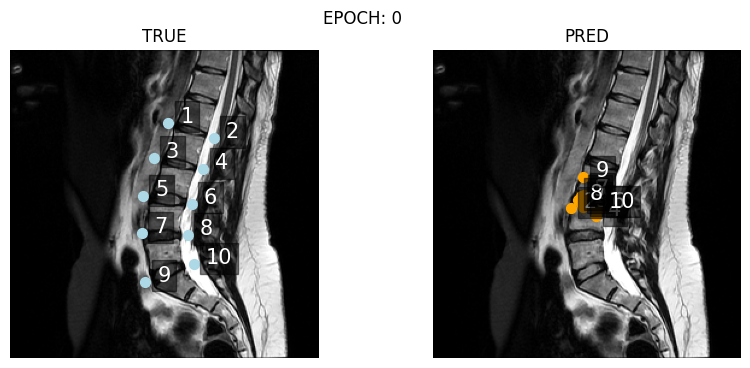

Epoch 1, Training Loss: 0.0, Validation Loss: 0.026954639554023743


100%|██████████| 25/25 [02:07<00:00,  5.12s/it]


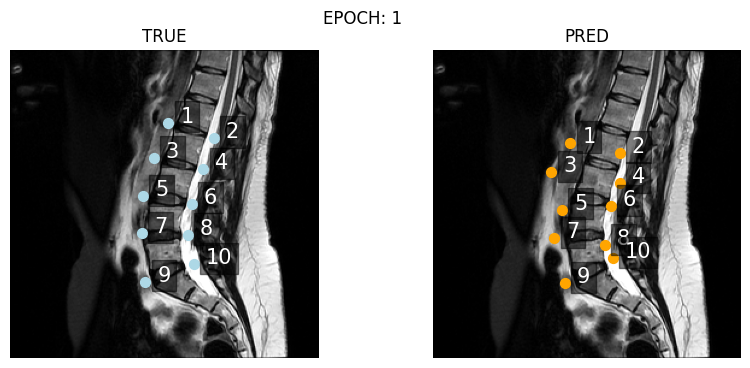

Epoch 2, Training Loss: 0.0017052205512300134, Validation Loss: 0.0019685693411156534


100%|██████████| 25/25 [02:08<00:00,  5.12s/it]


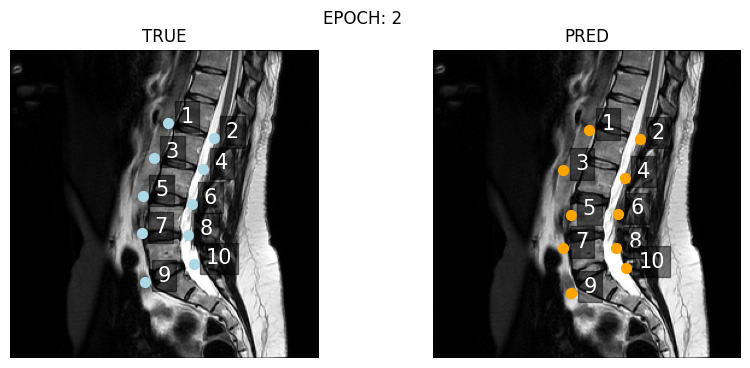

Epoch 3, Training Loss: 0.0010009532561525702, Validation Loss: 0.0011209642584435642


100%|██████████| 25/25 [02:04<00:00,  5.00s/it]


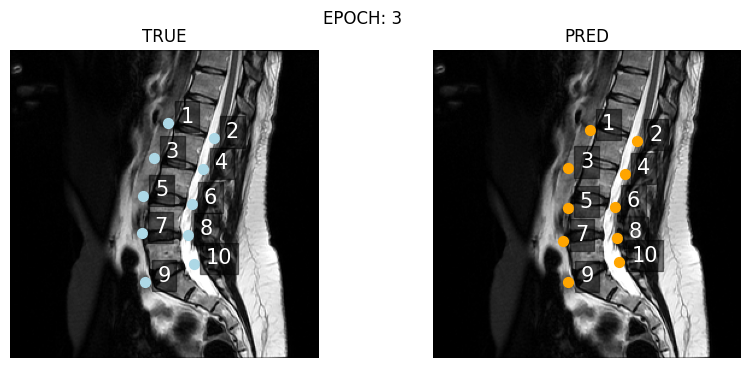

Epoch 4, Training Loss: 0.0008718757890164852, Validation Loss: 0.000834085086826235


100%|██████████| 25/25 [02:05<00:00,  5.01s/it]


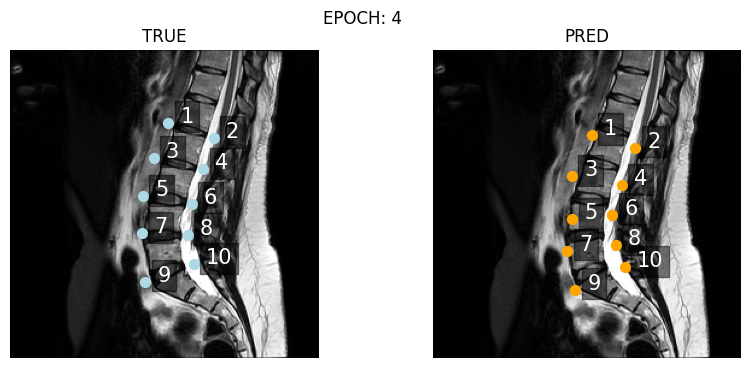

Epoch 5, Training Loss: 0.00045984561438672245, Validation Loss: 0.0007534236728679389


100%|██████████| 25/25 [02:06<00:00,  5.04s/it]


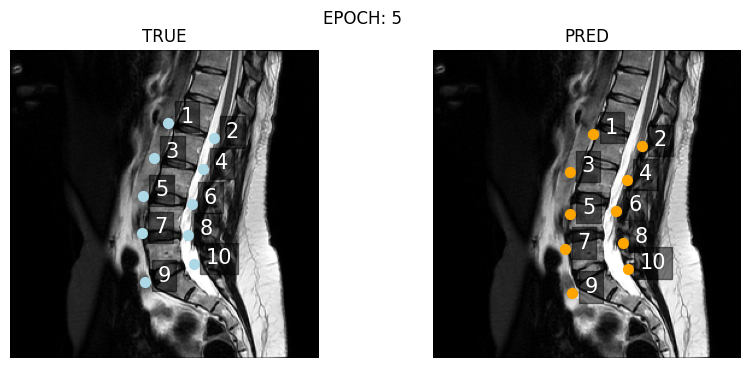

Epoch 6, Training Loss: 0.0006845461903139949, Validation Loss: 0.0007122099190019071


100%|██████████| 25/25 [02:05<00:00,  5.01s/it]


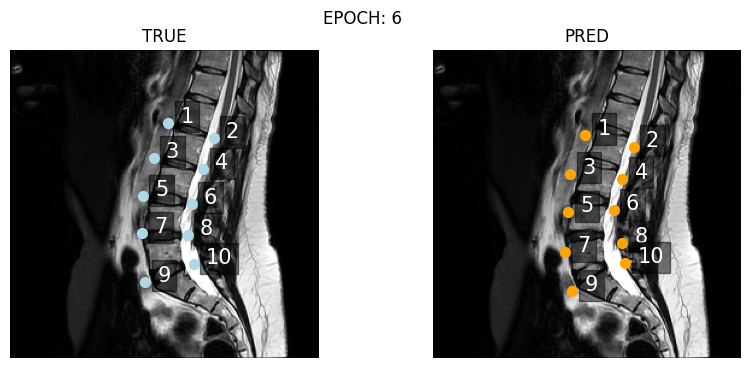

Epoch 7, Training Loss: 0.0002614269615150988, Validation Loss: 0.0006020478042773902


100%|██████████| 25/25 [02:04<00:00,  4.99s/it]


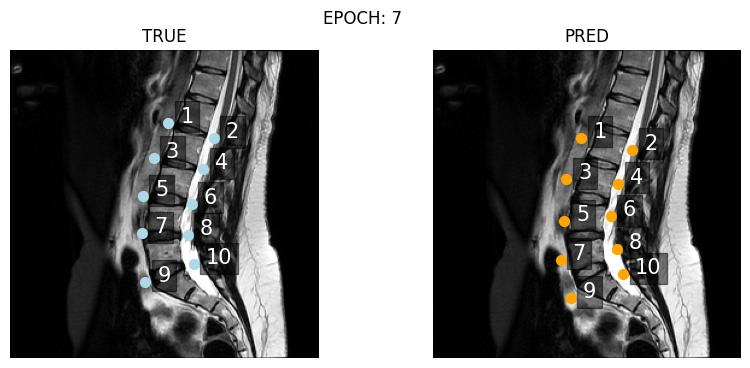

Epoch 8, Training Loss: 0.0003361710114404559, Validation Loss: 0.0008888149121776223


100%|██████████| 25/25 [02:06<00:00,  5.05s/it]


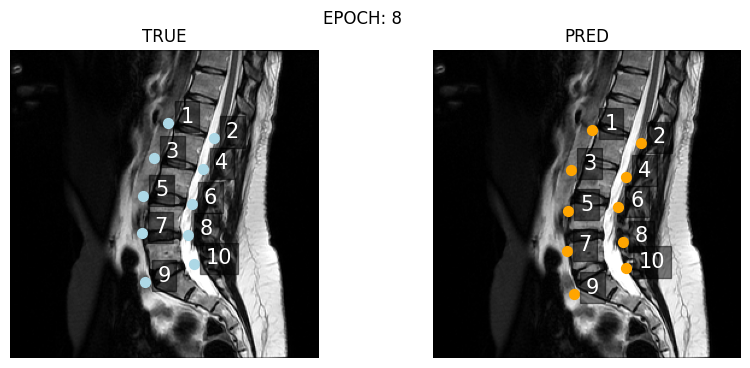

Epoch 9, Training Loss: 0.00014942428970243782, Validation Loss: 0.0005704959179274738


100%|██████████| 25/25 [02:07<00:00,  5.11s/it]


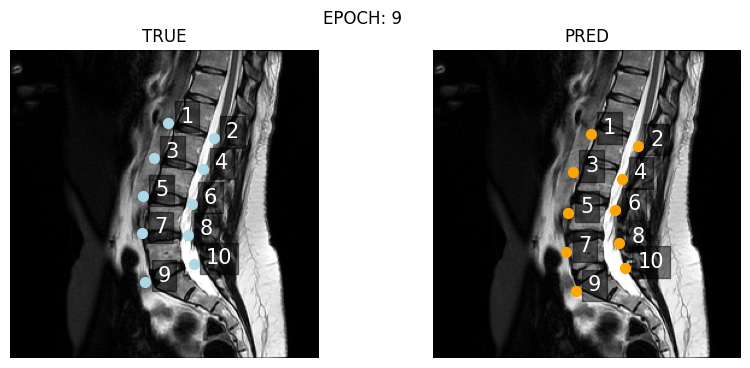

Epoch 10, Training Loss: 0.00015022566367406398, Validation Loss: 0.0005663218058180063


100%|██████████| 25/25 [02:06<00:00,  5.04s/it]


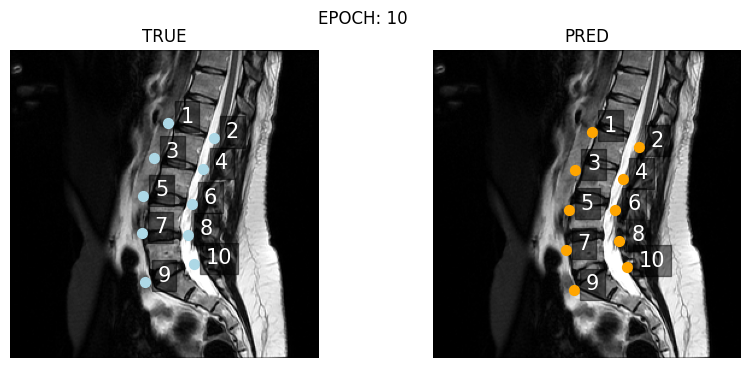

Epoch 11, Training Loss: 0.0002110709756379947, Validation Loss: 0.0005271038739010691
Training complete...


In [65]:
for epoch in range(cfg.epochs+1):
    
    # Train Loop
    loss= torch.tensor([0.]).float().to(cfg.device)
    if epoch != 0:
        model= model.train()
        for batch in tqdm(train_dl):
            batch = batch_to_device(batch, cfg.device)
            optimizer.zero_grad()

            x_out = model(batch["img"].float())
            x_out = torch.sigmoid(x_out)

            loss = criterion(x_out, batch["label"].float())
            loss.backward()
            optimizer.step()
        
    # Validation Loop
    val_loss = 0
    with torch.no_grad():
        model = model.eval()
        for batch in tqdm(val_dl):
            batch = batch_to_device(batch, cfg.device)

            pred = model(batch["img"].float())
            pred = torch.sigmoid(pred)
            
            val_loss += criterion(pred, batch["label"].float()).item()
        val_loss /= len(val_dl)
            
    # Viz
    visualize_prediction(batch, pred, epoch)           
            
    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
print("Training complete...")

## Save

Next, we save the backbone weights.

In [66]:
f= "{}_{}.pt".format(cfg.backbone, cfg.seed)
torch.save(model.state_dict(), f)
print("Saved weights: {}".format(f))

Saved weights: resnet18_0.pt


Finally, the weights can be loaded for a new task (eg. this competition).

In [67]:
# Load backbone for RSNA 2024 task
model = timm.create_model('resnet18', pretrained=True, num_classes=75)
model = model.to(cfg.device)
load_weights_skip_mismatch(model, f, cfg.device)

Skipping param: fc.weight, torch.Size([20, 512]) != torch.Size([75, 512])
Skipping param: fc.bias, torch.Size([20]) != torch.Size([75])
Loaded weights from: resnet18_0.pt
